In [8]:
import numpy as np
import pandas as pd
import re
from sklearn.decomposition import TruncatedSVD,NMF,LatentDirichletAllocation
import hazm
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from hazm import word_tokenize,Stemmer,Lemmatizer,POSTagger
from farsi_tools import stop_words,standardize_persian_text
from gensim.corpora import Dictionary
import gensim
from gensim.models import Word2Vec
from  PersianStemmer import PersianStemmer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from negar.virastar import PersianEditor
from symspellpy import SymSpell,Verbosity
from matplotlib import pyplot as plt
from nltk import FreqDist
pos_tag=POSTagger(model='pos_tagger.model')
per_stem=PersianStemmer()
stem=Stemmer()
lem=Lemmatizer()

# Packages
**1 hazm : using for persian language analyze like lemtizing, stemming ,tokenizing ,...**
**2 PersianStemmer: this is better than hazm in stemming**
**3 farsi_tools: another toolkit for persian language ,it has large renge of persian stopwords**
**4 sklearn decomposition: importing topic modeling algorithm like LDA,..**
**5 gensim : a library for unsupervised topic modeling**
**6 nltk : a toolkit for nlp**
**7 symspellpy : for checking spell of words**

In [9]:
# add custom stopword with fasttest stopwords
with open('stopwords.txt',encoding="utf8") as f:
    stop=f.readlines()
# cleaning stopwords
stop_word=[word.replace('\n','') for word in stop]
stop_word=[re.sub('[\\u200c]',' ',word)  for word in stop_word]
stop_word.extend(stop_words())

# Reading  Data

In [10]:
# 7 col in dataset ,just need 'body'
dataset=pd.read_csv('Corpus/asriran.csv')[:100]
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      100 non-null    object
 1   shortlink  100 non-null    object
 2   time       100 non-null    object
 3   service    100 non-null    object
 4   subgroup   100 non-null    object
 5   abstract   88 non-null     object
 6   body       93 non-null     object
dtypes: object(7)
memory usage: 5.6+ KB


In [11]:
# checking null values
dataset.isnull().sum()

title         0
shortlink     0
time          0
service       0
subgroup      0
abstract     12
body          7
dtype: int64

In [12]:
# separating uor data from dataset and convert to string
dataset=pd.DataFrame(dataset['body']).astype('string')
# removing junk value
dataset=dataset[dataset['body'].str.contains('<NA>')==False]
dataset.dropna()
dataset.reset_index(inplace=True,drop=True)

# Preprocessing
*1: extra word and symbol in text*
*2: tokenize data*
*3: tag words with hazm_tagger that based of StanfordPOSTagger*
*4: we need Nouns,split Noun_tags_words*
*5: lemmatize words with hazm_lemmatizer (finding root of words )*
*6: stemming word (removing extra data that words contain*
                                                  *7: removing word that has 1 character*
                                                                               *8: remover stopwords with farsi_tools stopwords*

In [13]:
data=pd.Series(name='title')
# iterate in dataset (return col)
for i,r in dataset.iterrows():
    title=r['body']
    # removing English word
    text=re.sub('[A-Za-z]','',title)
    # removing digit
    text=re.sub(r'[\d+]','',text)
    # remove extra spaces
    text=re.sub('[ ]{1,}',' ',text)
    # remove punctuation and \u200c
    text = re.sub(r'[!@#$%^&*(),.?":{}|<>/«»،؛؟…_\-+\\\u200c]','', text)
    text=re.sub('[\xa0]','',text)
    # join word and ading to data
    data.loc[i]=''.join(text)

**characters**

In [100]:
# remove repetitive characters

# def remover_rept_words(word):
#     pre_word=''
#     words=[]
#     for w in [w for w in word]:
#         if w!=pre_word:
#             words.append(w)
#             pre_word=w
#     print(''.join(words))
# remover_rept_words('حاااالتتت چطططووورههه')
# output ----> حالت چطوره


In [73]:
# tokenize data,separate text to words
token=[word_tokenize(word) for word in data]

# remove stop words
token=[[word for word in words if word not in stop_word]for words in token]

# lematize ,
#lem.lemmatize('رفت') ---> 'رفت#رو'
#token=[[lem.lemmatize(word) for word in words] for words in token]

# makgin n-grams, merge two or more word thar related to each-other in text ("ایت","الله","کاشانی",--->'ایت_الله_کاشانی ") 3-gram
two_gram = gensim.models.Phrases(token, min_count=1, threshold=100)
tree_gram = gensim.models.Phrases(two_gram[token], threshold=100)
four_gram = gensim.models.Phrases(tree_gram[token], threshold=100)
five_gram= gensim.models.Phrases(four_gram[token], threshold=100)

# making n-gram models
two_gram_model= gensim.models.phrases.Phraser(two_gram)
tree_gram_model = gensim.models.phrases.Phraser(tree_gram)
four_gram_model = gensim.models.phrases.Phraser(five_gram)
five_gram_model = gensim.models.phrases.Phraser(five_gram)

#convert word with n-grams
token=[five_gram_model[four_gram_model[tree_gram_model[two_gram_model[word]]]] for word in token]

#pos_tag with hazm (NOUN,ADJ,VRB,...) for extracting features
# "مشاور" --->> ('مشاور', 'NOUN,EZ')
token=[pos_tag.tag(word) for word in token]

# select 'NOUN,NOUN,EZ' words
taged_token=[]
for word in token:
    nouns=[]
    for word,por in word :
        if por=='NOUN':
            nouns.append(word)
        if por=='NOUN,EZ':
            nouns.append(word)
    taged_token.append(nouns)

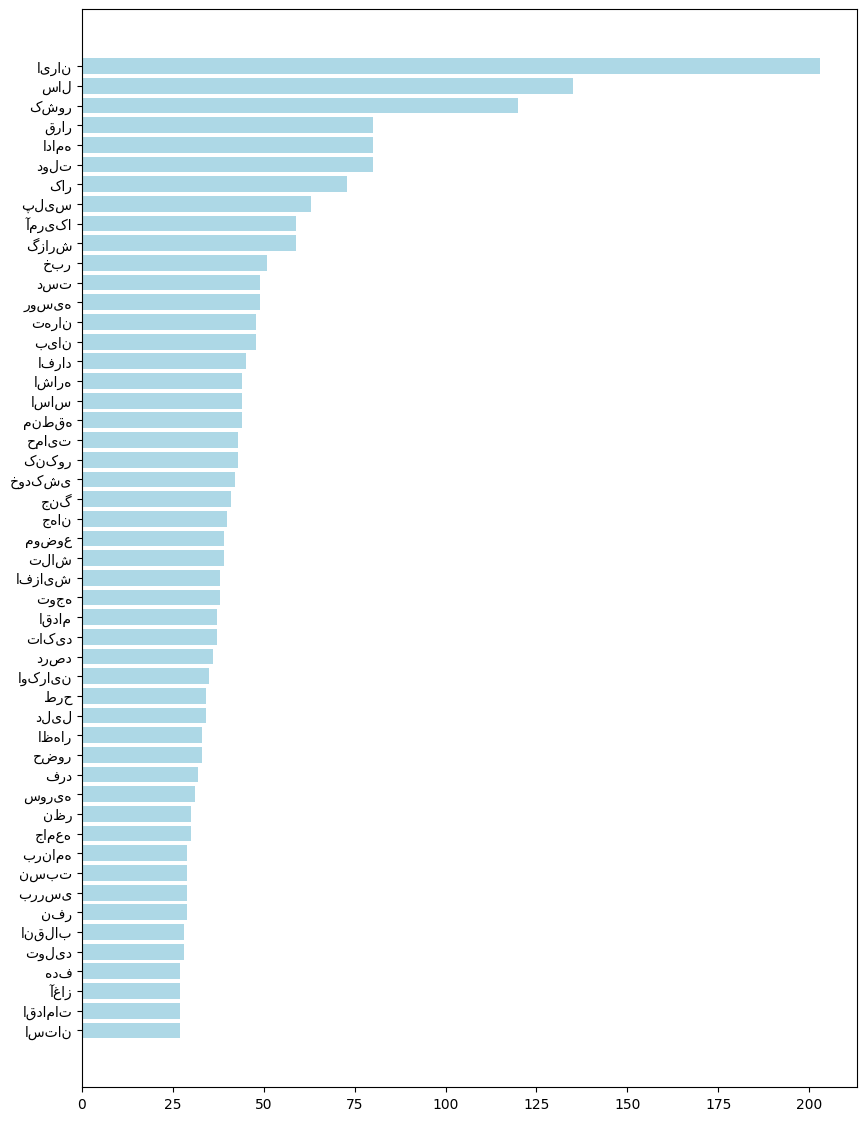

In [23]:
#  commen word with FreqDist , it can be used for some stop words,which words repeated more than others
# ('سال', 135)
com_word=FreqDist([word for words in taged_token for word in words]).most_common(50)
word_list = com_word[::-1]
# extracting comment words for plotting and stop words
fe_words,freq = [],[]
for word in word_list:
    fe_words.append(word[0])
    freq.append(word[1])
x=np.array(fe_words)
y=np.array(freq)

plt.figure(figsize=(10,14))
plt.barh(x,y,color="lightblue")
plt.show()


In [76]:
# removing most comment word
stop=fe_words[-20::-1]
final_cop=[]
for taged in taged_token:
    words=[]
    for word in taged:
        if word not in stop:
            words.append(word)
    final_cop.append(words)
#final_cop=taged_token

# make model with sklearn

In [77]:
# usings  TF-IDF for making bag of words
tfidf_vec=TfidfVectorizer(ngram_range=(1,3),min_df=3,max_df=0.95)
# fiting ccorpus
tfidf_vec_fit=tfidf_vec.fit_transform([' '.join(word) for word in final_cop]).toarray()
#id to word
tfidf_vec_get_feature=tfidf_vec.get_feature_names_out()
print(tfidf_vec_get_feature)

['آب' 'آتش' 'آثار' 'آخرین_وضعیت' 'آدم' 'آزادی' 'آسمان' 'آسیب' 'آلمان'
 'آلمانی' 'آلودگی' 'آمادگی' 'آمار' 'آمارهای' 'آمریکا' 'آموزش' 'آنجایی'
 'آگاهی' 'آیت_الله' 'آینده' 'آیین' 'ابراز' 'ابراهیم' 'ابزار' 'ابعاد'
 'اتحادیه_اروپا' 'اتصال' 'اتفاق' 'اتهام' 'اجازه' 'اجرا' 'اجرای' 'احتمال'
 'احساس' 'احساسات' 'اخبار' 'اختیار' 'اداره' 'ادامه' 'ادعا' 'ادعای' 'ارائه'
 'ارتباط' 'ارتش' 'ارتفاع' 'ارتقای' 'ارتکاب' 'ارجاع' 'اردیبهشت' 'ارز'
 'ارزش' 'ارزها' 'ارزیابی' 'ارسال' 'اروپا' 'اساس' 'اساس گزارش'
 'استان_هرمزگان' 'استانداردهای' 'استانها' 'استانهای' 'استقبال' 'استقلال'
 'اسلام' 'اشاره' 'اشتباه' 'اشک' 'اصل' 'اصلاح' 'اصول' 'اطلاع' 'اطلاع_رسانی'
 'اطلاعات' 'اطمینان' 'اظهارات' 'اظهارداشت' 'اعتراف' 'اعتراف_متهم' 'اعتماد'
 'اعضای' 'اعمال' 'افراد' 'افرادی' 'افزایش_قیمت' 'اقتصاد' 'اقداماتی'
 'اقدامی' 'اقلام' 'التماس' 'الملل' 'المللی' 'امام' 'امتحان' 'امر' 'امریکا'
 'امضا' 'امضای' 'امنیت' 'امکان' 'امیر' 'انتخاب' 'انتخابات' 'انتشار'
 'انتظار' 'انتقاد' 'انتقادات' 'انتقال' 'انجمن' 'انحلال' 'اندازه' 'انفجار'
 'ا

In [78]:
# NFM (sklearn)
#  reducing the number of features while retaining the basis information necessary to reconstruct the original data. Basically,
model_NFM=NMF( n_components=50,
               init='nndsvd',
               max_iter=100,
               l1_ratio=0.0,
               solver='mu',
               alpha_W=0.0,
               tol=1e-4,
               random_state=42)
model_NFM.fit(tfidf_vec_fit)



C:\ProgramData\anaconda3\envs\nlp\lib\site-packages\sklearn\decomposition\_nmf.py:1561: UserWarning: The multiplicative update ('mu') solver cannot update zeros present in the initialization, and so leads to poorer results when used jointly with init='nndsvd'. You may try init='nndsvda' or init='nndsvdar' instead.
  warnings.warn(


NMF(init='nndsvd', max_iter=100, n_components=50, random_state=42, solver='mu')

In [79]:
# merge genrated label with text
def topic_table(n_top_words, feature_names, nmf):
    topics = {}
    for i, topic_vec in enumerate(nmf.components_):
        topic_descr = ''
        for fid in topic_vec.argsort()[-1:-n_top_words-1:-1]:
            topic_descr = topic_descr + feature_names[fid] + " "
        topics[i] = topic_descr
    return pd.DataFrame({'top_topic': topics})

topic_df = topic_table(6, tfidf_vec_get_feature, model_NFM)
doc_vec = model_NFM.transform(tfidf_vec.transform([' '.join(word) for word in final_cop]))
dataset["topic_in"] = doc_vec.argmax(axis=1)
# Joining the original dataset with labels
df = pd.merge(dataset, topic_df, left_on='topic_in', right_index=True, how='left')
df


C:\ProgramData\anaconda3\envs\nlp\lib\site-packages\sklearn\decomposition\_nmf.py:1561: UserWarning: The multiplicative update ('mu') solver cannot update zeros present in the initialization, and so leads to poorer results when used jointly with init='nndsvd'. You may try init='nndsvda' or init='nndsvdar' instead.
  warnings.warn(


,body,topic_in,top_topic
0,رئیس پلیس آگاهی تهران بزرگ اعلام کرد که موضوع ...,1,پلیس سرقت تهران ماموران پرونده کشف
1,"وزیر بهداشت جزییات طرح ""دارویار"" که اجرای آن آ...",30,تومان بیماران هزینههای مجلس_شورای_اسلامی دارو ...
2,سخنگوی وزارت بهداشت، درمان و آموزش پزشکی در تو...,8,وزارت_بهداشت رئیس کشور دارو کرونا مراجعه
3,معاون رئیس جمهور گفت: دولت برنامه های راهبردی ...,11,دولت پیشرفت رئیس_جمهور مسئولیت دیدار ایجاد
4,رییس پلیس فتا فرماندهی انتظامی گلستان گفت: سار...,48,سرقت کارشناسان سایبری شهروندان کشف قرار
...,...,...,...
88,نقشی است که انجام آن به انواع مختلف وسایل نقلی...,47,حمل ظرفیت انواع خودروهای وزن شرایطی
89,رحیم‌پور ازغدی گفت: آمریکا با عنوان مدرنیته جن...,4,آمریکا ناتو سال کشورش ایالات_متحده خانواده
90,تیم هندبال دختران ایران توانست با برتری برابر ...,2,ایران برجام تاریخ برنامه_هستهای هستهای بیانیه
91,محققان معتقد هستند که برخلاف کلیشه های جنسیتی ...,26,زنان گروه مردان احساسات تفاوت مطالعه


In [80]:
#  Latent Dirichlet allocation (TruncatedSVD is LDA in sklearn )
# it based on Documents topic matrix and topic word matrix
model_LDA=LatentDirichletAllocation(n_components=25,
                                    learning_method='batch'
                                    ,random_state=42
                                    ,max_iter=200
                                    )
model_LDA.fit_transform(tfidf_vec_fit)

def topic_table(n_top_words, feature_names, nmf):
    topics = {}
    for i, topic_vec in enumerate(nmf.components_):
        topic_descr = ''
        for fid in topic_vec.argsort()[-1:-n_top_words-1:-1]:
            topic_descr = topic_descr + feature_names[fid] + " "
        topics[i] = topic_descr
    return pd.DataFrame({'top_topic': topics})

topic_df = topic_table(10, tfidf_vec_get_feature, model_LDA)
doc_vec = model_LDA.transform(tfidf_vec.transform([' '.join(word) for word in final_cop]))
dataset["Topic_idx"] = doc_vec.argmax(axis=1)

df = pd.merge(dataset, topic_df, left_on='Topic_idx', right_index=True, how='left')
df


,body,topic_in,Topic_idx,top_topic
0,رئیس پلیس آگاهی تهران بزرگ اعلام کرد که موضوع ...,1,5,ایران سال کشور پلیس دولت قرار کار خبر آمریکا ا...
1,"وزیر بهداشت جزییات طرح ""دارویار"" که اجرای آن آ...",30,21,بیماران هزینههای تومان مجلس_شورای_اسلامی نفر_ج...
2,سخنگوی وزارت بهداشت، درمان و آموزش پزشکی در تو...,8,5,ایران سال کشور پلیس دولت قرار کار خبر آمریکا ا...
3,معاون رئیس جمهور گفت: دولت برنامه های راهبردی ...,11,22,مواد_مخدر شنبه بیماری توزیع دیدار کشورهای نصب ...
4,رییس پلیس فتا فرماندهی انتظامی گلستان گفت: سار...,48,5,ایران سال کشور پلیس دولت قرار کار خبر آمریکا ا...
...,...,...,...,...
88,نقشی است که انجام آن به انواع مختلف وسایل نقلی...,47,5,ایران سال کشور پلیس دولت قرار کار خبر آمریکا ا...
89,رحیم‌پور ازغدی گفت: آمریکا با عنوان مدرنیته جن...,4,5,ایران سال کشور پلیس دولت قرار کار خبر آمریکا ا...
90,تیم هندبال دختران ایران توانست با برتری برابر ...,2,5,ایران سال کشور پلیس دولت قرار کار خبر آمریکا ا...
91,محققان معتقد هستند که برخلاف کلیشه های جنسیتی ...,26,10,ستاد زنان دستگاههای_اجرایی شنبه خلیج_فارس مردا...




# LDA

In [81]:
 # LDA with gensim
# make corpus to dic
dictionary=Dictionary(final_cop)
dictionary.filter_extremes(no_below=5,no_above=0.95)
# make bag of word with frequency and chane to numeric
co=[dictionary.doc2bow(word) for word in final_cop]
# LDA model
ld=gensim.models.ldamodel.LdaModel(    corpus=co,
                                       id2word=dictionary,
                                       num_topics=10,
                                       random_state=100,
                                       update_every=1,
                                       chunksize=10,
                                       passes=10,
                                       alpha='auto',
                                       iterations=100,
                                   )

print(ld.print_topics())

[(0, '0.083*"کشور" + 0.069*"سال" + 0.050*"گروه" + 0.040*"ادامه" + 0.030*"کار" + 0.026*"منطقه" + 0.025*"دولت" + 0.020*"فضای_مجازی" + 0.019*"بازی" + 0.019*"پایان"'), (1, '0.050*"زنان" + 0.027*"تاریخ" + 0.026*"دختر" + 0.026*"سازمان" + 0.020*"نتیجه" + 0.019*"مطالعه" + 0.018*"تشکیل" + 0.018*"تفاوت" + 0.017*"ماه" + 0.017*"ارتباط"'), (2, '0.200*"گزارش_ایرنا" + 0.187*"دانشگاه" + 0.129*"قلب" + 0.041*"وزارت_بهداشت" + 0.041*"تکمیل" + 0.037*"درد" + 0.033*"صدور" + 0.017*"پزشکی" + 0.007*"آیین" + 0.001*"کف"'), (3, '0.147*"شکل" + 0.104*"تجربه" + 0.069*"درمان" + 0.052*"تقویت" + 0.047*"اقتصاد" + 0.040*"رضا" + 0.039*"جذب" + 0.037*"علم" + 0.036*"منابع" + 0.035*"پیشنهاد"'), (4, '0.396*"ایران" + 0.048*"توسعه" + 0.040*"جدیت" + 0.038*"ارائه" + 0.031*"غرب" + 0.030*"وزارت" + 0.025*"توافق" + 0.022*"رئیس_جمهور" + 0.021*"دست" + 0.020*"کشورمان"'), (5, '0.064*"اساس" + 0.060*"آمریکا" + 0.043*"گزارش" + 0.043*"اشاره" + 0.036*"تهران" + 0.033*"ایجاد" + 0.033*"وضعیت" + 0.032*"مقابله" + 0.027*"حالی" + 0.025*"پلیس"'), (6, '

In [82]:
# measuring the degree of semantic similarity between high scoring words in the topic.
cor=gensim.models.CoherenceModel(model=ld,
                                 texts=final_cop,
                                 dictionary=dictionary,
                                 coherence='c_v')
cor.get_coherence()


0.3519564283710632

In [83]:
topics_to_dataset=pd.DataFrame()
for i, j in enumerate(ld[co]):
    row=sorted(j,key=lambda x:(x[1]),reverse=True)
    for j,(top_n,top_val) in enumerate(row):
        if j==0 :
            wp=ld.show_topic(top_n)
            top_key=' '.join([word[0] for word in wp][:7])
            topics_to_dataset=topics_to_dataset._append(pd.Series([top_key]), ignore_index=True)
topics_to_dataset.columns = [ 'topic_key']
content=pd.Series(data)
topics_to_dataset=pd.concat([topics_to_dataset,content],axis=1)
topics_to_dataset.columns = ['topic_key', 'Text']
topics_to_dataset

,topic_key,Text
0,اساس آمریکا گزارش اشاره تهران ایجاد وضعیت,رئیس پلیس آگاهی تهران بزرگ اعلام کرد که موضوع ...
1,اساس آمریکا گزارش اشاره تهران ایجاد وضعیت,وزیر بهداشت جزییات طرح دارویار که اجرای آن آغا...
2,گزارش_ایرنا دانشگاه قلب وزارت_بهداشت تکمیل درد...,سخنگوی وزارت بهداشت درمان و آموزش پزشکی در توئ...
3,ایران توسعه جدیت ارائه غرب وزارت توافق,معاون رئیس جمهور گفت دولت برنامه های راهبردی ا...
4,بیان خبر خاطرنشان قرار اطلاعات رییس خصوص,رییس پلیس فتا فرماندهی انتظامی گلستان گفت سارق...
...,...,...
88,کشور سال گروه ادامه کار منطقه دولت,نقشی است که انجام آن به انواع مختلف وسایل نقلی...
89,اساس آمریکا گزارش اشاره تهران ایجاد وضعیت,رحیمپور ازغدی گفت آمریکا با عنوان مدرنیته جنای...
90,ایران توسعه جدیت ارائه غرب وزارت توافق,تیم هندبال دختران ایران توانست با برتری برابر ...
91,زنان تاریخ دختر سازمان نتیجه مطالعه تشکیل,محققان معتقد هستند که برخلاف کلیشه های جنسیتی ...


In [84]:
import pyLDAvis
from pyLDAvis import gensim_models
pyLDAvis.enable_notebook()
vis=gensim_models.prepare(ld,co,dictionary,mds='mmds',R=10)
vis

C:\ProgramData\anaconda3\envs\nlp\lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.022662  0.379767       1        1  24.769454
1      0.028451 -0.395447       2        1  22.624113
5     -0.413690 -0.101536       3        1  20.981120
8     -0.283684  0.295990       4        1  12.813630
4      0.374503 -0.247884       5        1   9.501142
6      0.294536  0.019835       6        1   2.796652
9      0.249513  0.254538       7        1   2.723979
3     -0.110304 -0.206097       8        1   2.097755
2     -0.159077  0.032074       9        1   1.674784
7     -0.002910 -0.031241      10        1   0.017370, topic_info=        Term        Freq       Total Category  logprob  loglift
75     ایران  201.000000  201.000000  Default  10.0000  10.0000
55      دولت   70.000000   70.000000  Default   9.0000   9.0000
98      بیان   98.000000   98.000000  Default   8.0000   8.0000
335    روسیه   35.000000   35.000000  Default   7.0000   7.0000
66      کشور  120.000000  120.000000  Default   6.0000   6.0000
..       ...         ...         ...      ...      ...      ...
5      اطلاع    0.002441    5.945165  Topic10  -5.9402   0.8604
6       امام    0.002441    4.484951  Topic10  -5.9402   1.1423
7     انتشار    0.002441   11.397972  Topic10  -5.9402   0.2096
8        بحث    0.002441    8.933850  Topic10  -5.9402   0.4531
9    تحقیقات    0.002441   12.392394  Topic10  -5.9402   0.1259

[135 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
0         3  0.834933         آمار
1         3  0.728689      آمارهای
131       3  0.994734       آمریکا
2         4  0.952294        آگاهی
68        8  0.444054         آیین
...     ...       ...          ...
369       8  0.900685           کف
190       1  0.990751          کمک
191       1  0.991735         گروه
204       3  0.994104        گزارش
73        9  0.968546  گزارش_ایرنا

[137 rows x 3 columns], R=10, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 6, 9, 5, 7, 10, 4, 3, 8])

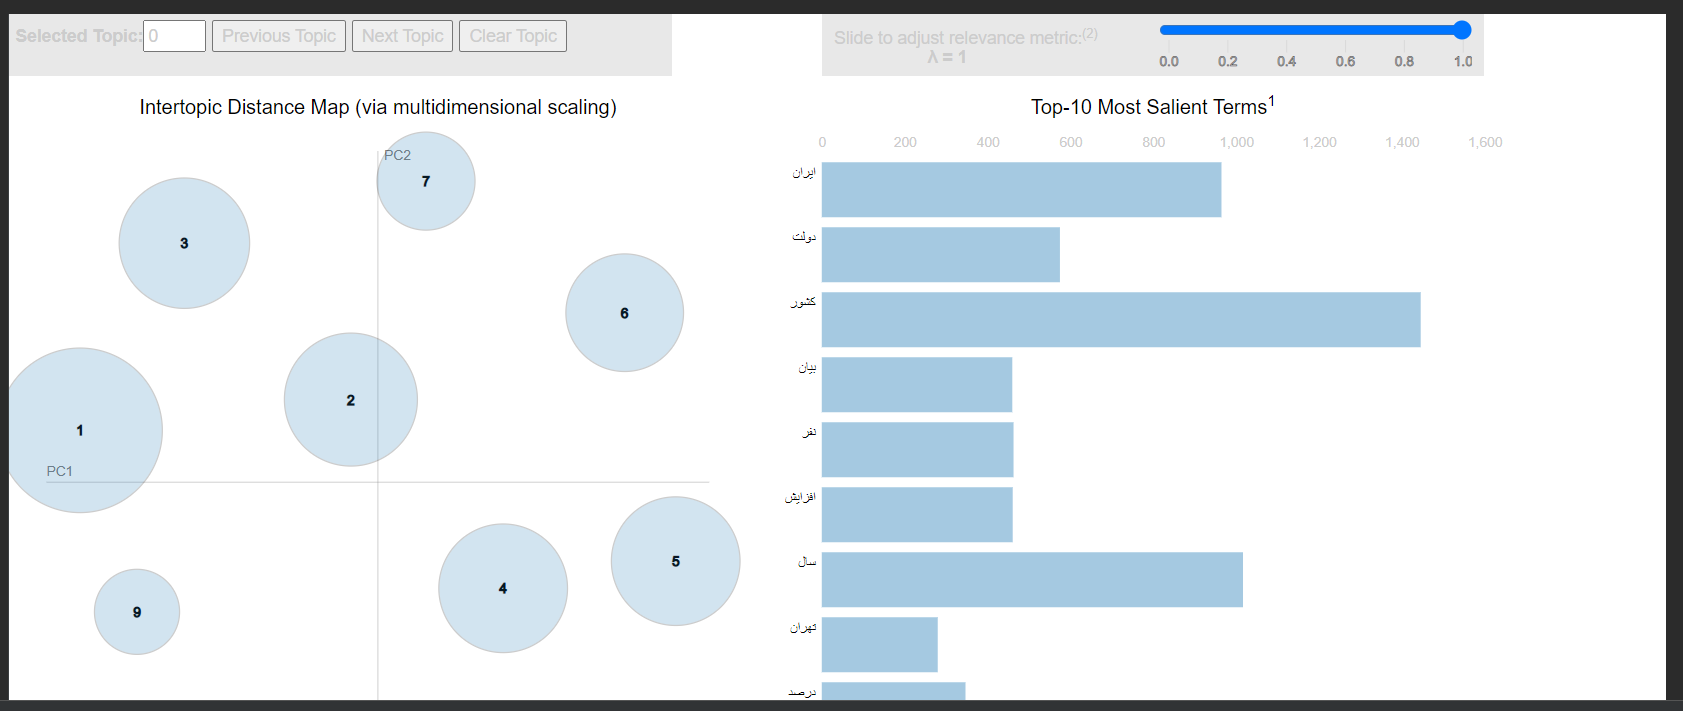

In [85]:
from IPython import display
display.Image('img.png')

# NMF

In [86]:
from gensim.models import Nmf
nmf = Nmf(
    corpus=co,
    num_topics=15,
    id2word=dictionary,
    chunksize=100,
    passes=5,
)


C:\ProgramData\anaconda3\envs\nlp\lib\site-packages\gensim\models\nmf.py:578: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  if isinstance(corpus, scipy.sparse.csc.csc_matrix):
C:\ProgramData\anaconda3\envs\nlp\lib\site-packages\gensim\models\nmf.py:607: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  if isinstance(corpus, scipy.sparse.csc.csc_matrix):
C:\ProgramData\anaconda3\envs\nlp\lib\site-packages\gensim\models\nmf.py:620: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  if isinstance(corpus, scipy.sparse.csc.csc_matrix):
C:\ProgramData\anaconda3\envs\nlp\lib\site-packages\gensim\models\nmf.py:607: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  if isinstance(co

In [87]:
cor=gensim.models.CoherenceModel(model=nmf,
                                 texts=final_cop,
                                 dictionary=dictionary,
                                 coherence='c_v')
cor.get_coherence()

0.4037647937747909

In [88]:
topics_to_dataset=pd.DataFrame()
for i, j in enumerate(nmf[co]):

    row=sorted(j,key=lambda x:(x[1]),reverse=True)

    for j,(top_n,top_val) in enumerate(row):
        if j==0 :
            wp=nmf.show_topic(top_n)
            top_key=' '.join([word[0] for word in wp][:5])
            topics_to_dataset=topics_to_dataset._append(pd.Series([ top_key]), ignore_index=True)
topics_to_dataset.columns = [ 'topic_key']
content=pd.Series(data)
topics_to_dataset=pd.concat([topics_to_dataset,content],axis=1)
topics_to_dataset.columns = ['topic_key', 'Text']
topics_to_dataset

,topic_key,Text
0,پلیس ماموران تهران خبر سرقت,رئیس پلیس آگاهی تهران بزرگ اعلام کرد که موضوع ...
1,بیان دولت کشور تهران سرقت,وزیر بهداشت جزییات طرح دارویار که اجرای آن آغا...
2,بیان دولت کشور تهران سرقت,سخنگوی وزارت بهداشت درمان و آموزش پزشکی در توئ...
3,بیان دولت کشور تهران سرقت,معاون رئیس جمهور گفت دولت برنامه های راهبردی ا...
4,بیان دولت کشور تهران سرقت,رییس پلیس فتا فرماندهی انتظامی گلستان گفت سارق...
...,...,...
88,آمریکا بیان پلیس خانواده اشاره,نقشی است که انجام آن به انواع مختلف وسایل نقلی...
89,ایران آمریکا ادامه سیاست سازمان_ملل,رحیمپور ازغدی گفت آمریکا با عنوان مدرنیته جنای...
90,کار زنان سال آمریکا قرار,تیم هندبال دختران ایران توانست با برتری برابر ...
91,بیان دولت کشور تهران سرقت,محققان معتقد هستند که برخلاف کلیشه های جنسیتی ...
